
# LINMA2472 - Algorithms in Data Science
# Homework 3: GAN and CNN to conquer MNIST
# Part 1: Implementation
Bastien Massion - bastien.massion@uclouvain.be

09 November 2022

## Guidelines
This homework is done in Python, using the PyTorch library for neural networks. 

The homework is divided in 2 parts, this Notebook is the assignment for part 1. The second part will become available next week. The goal of the homework is to use a GAN for generating handwritten numbers (and letters) and a CNN to classify them. This first part is dedicated to the implementation, the second part will focus on analyzing and using the neural networks.

The exact instructions for the report will come with the second part. However, every task asked in this Notebook will be useful, so get ahead!

As for the previous homeworks, you are making groups of 3, in the Moodle activity "Group choice for assignment 3".

The deadline for the whole homework is: 30 November 2022, 23:59.

Your questions should be posted on the dedicated Moodle "Class forum" or sent directly to the mail address: bastien.massion@uclouvain.be.

## Introduction
Since their introduction in 2014 by Goodfellow et al., Generative Adversarial Networks (GAN) have taken a predominant place in the deep learning landscape. GANs are deep neural networks composed of two parts: a generator and a discriminator. Those two parts are trained as opponents (hence "adversarial"): from the dataset, the generator tries to create new fake data that can fool the discriminator into thinking they are real, while the discriminator tries to distinguish between true and fake data. Often, the most interesting part of this model is the generator, therefore we often refer to GANs as generative models (even if they are also discriminative models). This generative property is used in a lot of applications: mainly for image processing task (style transfer, segmentation, face generation, image inpainting, deblurring, super-resolution,...), but also for natural language processing tasks (text summarization, text generation,...), for music generation or even for medical tasks (tumor detection).

Another powerful architecture is Convolutional Neural Networks (CNN). CNNs naturally exploit invariances that are present in data (such that translation in images) in order, for example, to classify them. This is done by applying successive convolutions on data in order to extract the main features. Together with the backpropagation algorithm, the invention of CNN marked the revival of neural networks and deep learning in the 90's. Since then, they have found plenty of applications, mostly in image processing tasks.

The goal of this homework in two parts is to implement your first GAN as well as your first CNN, to explore some properties and finally to combine them in order to generate what you desire.

## Packages import
You will need several packages in order to successfully build, train and use your neural networks. 

The following packages are necessary and should not be removed. However, if you want to add other packages for your figures, for timing or whatever, feel free to do so.

In [119]:
# PyTorch is a common library for neural networks in Python. torch.nn is a module for building layers of Neural Networks.
import torch
from torch import nn
import torch.nn.functional as F
# TorchVision is part of the PyTorch environment. It is necessary to download the datasets MNIST (and EMNIST Letters)
import torchvision
import torchvision.transforms as transforms

# Usual mathematical stuff
import numpy as np
import math

# Plots
import matplotlib.pyplot as plt

# Timing
import time
from datetime import datetime

## Resources
Training neural networks is really expensive, especially if your networks are large. It is thus important to look for the most suited computing and storing resources.

In practice, parallelisation of computations can speed up the process a lot, by several orders of magnitude. In particular, computing on a GPU (Graphics Processing Unit), which has up to hundreds of cores, will be much faster than on your usual laptop CPU (Central Processing Unit), typically with less than 8 cores. 

Therefore, it is useful to search for the maximum available computing power.

Be reassured, this homework is doable on your standard laptop CPU.

But, if you want or need better equipments for this project, there are some solutions.

### What is available?
The function chooseDevice automatically checks if there is a GPU available. If there is one, computations will be done there. Simply be careful of adding ".to(device=device)" everywhere it will be needed in the rest of the code. Otherwise, computations will be done on CPU.

There should be no need to modify the function chooseDevice.

In [120]:
# Check if GPU is available

def chooseDevice():
    device = ""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU available via cuda")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU available")
    return device

In [121]:
device = chooseDevice()

GPU available via cuda


### I need more power: Google Colab
If you need or want more computing power, you can use Google Colab. Colab is a free and easy to use service from Google, where you can borrow their efficient resources. Often, GPU are not available (reserved in priority for people with paying subscriptions), but their CPU's are probably better than yours. You just need a Google account in order to run code online. Note that it works with Jupyter Notebooks, which is nice. 

If, despite this, you are not satisfied, feel free to contact Bastien Massion.

## Set random seed
Setting the seed for the generation of random numbers is not necessary, but can be useful for keeping consistency in your experiments.

In [122]:
_ = torch.manual_seed(2472) 

## Datasets
Two datasets are proposed. 

First, the classical MNIST set. MNIST is mandatory and sufficient to complete the whole homework. It contains a total of 70 000 handwritten digits (60 000 train, 10 000 test) from 10 balanced classes (one for each digit). You have already worked with it in the HW2.

Then, the EMNIST Letters set. This second dataset is larger (more data and more classes) and optional, but could be used to create more impressive results. It contains a total of 145 600 handwritten letters (124 800 train, 20 800 test) from 26 balanced classes (one for each latin letter, lowercase and uppercase mixed). For your information, EMNIST (Extended MNIST) contains several varations and extensions of MNIST.

### Load dataset
The datasets are loaded from the module torchvision.

There should be no need to modify the function getData.

In [123]:
# Extracts the train and test sets from a chosen image dataset
# Values of pixels are normalized between -1 and 1

def getData(dataset = "MNIST", info = True):
    if dataset == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=transform)
    elif dataset == "EMNIST_Letters":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = torchvision.datasets.EMNIST(root=".", split="letters", train=True, download=True, transform=transform)
        test_set = torchvision.datasets.EMNIST(root=".", split="letters", train=False, download=True, transform=transform)
    else:
        print("DATASET NOT CORRECTLY DEFINED")
    if info:
        print(train_set)
        print(test_set)
    return train_set, test_set

In [124]:
# Choose which dataset to use

dataset = "MNIST"
#dataset = "EMNIST_Letters"

train_set, test_set = getData(dataset = dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


### Get size of dataset
This function is just there to extract useful information about the (relative) sizes of the train and test sets.

There should be no need to modify the function dataSize.

In [125]:
# Get information about the size of the train and test sets.

def dataSize(train_set, test_set):
    n_train_set = train_set.__len__()
    n_test_set = test_set.__len__()
    n_tot = n_train_set + n_test_set
    ratio_train_test = n_train_set / n_test_set
    percentage_train = n_train_set / n_tot
    percentage_test = 1.0 - percentage_train
    return n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test

In [126]:
n_train_set, n_test_set, n_tot, ratio_train_test, percentage_train, percentage_test = dataSize(train_set, test_set)

### Divide dataset into batches
Computing the whole gradient for neural networks is too heavy, as it requires information about the whole dataset. Thus, we use (Mini-)Batch Gradient Descent. This is a variant of Stochastic Gradient Descent (SGD) in which we compute the gradient only for a small number of data, gathered in a batch. Typically, the batch size is orders of magnitude smaller than the whole dataset.

The function divideInBatches splits the dataset and loads the data.

You can modify the value of parameter batch_size as you wish.

There should be no need to modify the function divideInBatches.

In [127]:
# Paramater for the batch size
# Predefined value = 32

batch_size = 32

In [128]:
# Divide dataset into batches

def divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set):
    # Train set
    n_batches_total = math.ceil(n_train_set/batch_size)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    # Test set
    n_batches_total_test = math.ceil(n_test_set/batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader, n_batches_total, n_batches_total_test

In [129]:
train_loader, test_loader, n_batches_total, n_batches_total_test = divideInBatches(train_set, test_set, batch_size, n_train_set, n_test_set)

### Correct EMNIST Letters data
While the MNIST dataset is ready to be used, the EMNIST Letters data need to be slighty modified before use.

On the one hand, the x and y axes of the images are flipped, which is unpractical for the visualization.

On the other hand, the letters labels go from 1 to 26 (corresponding with their place in the alphabet) instead of from 0 to 25. This could be problematic and is better fixed directly.

Therefore, every time a batch is loaded, it should go through a little correcting function first.

There should be no need to modify the function correctData.

In [130]:
# Corrects EMNIST Letters data

def correctData(real_samples, mnist_labels, dataset):
    if dataset == "EMNIST_Letters":
        real_samples = torch.transpose(real_samples,2,3)
        mnist_labels -= 1
    return real_samples, mnist_labels

In [131]:
real_samples, mnist_labels = next(iter(train_loader))
real_samples, mnist_labels = correctData(real_samples, mnist_labels, dataset)

## Show images
During the whole homework, it will be important to show samples, either from the dataset, either ones your generate. Here is just a function that can help you visualizing and avoiding losing any plot that you once created. 

The function showImages allows to represent up to 16 images. You can precise if they are generated by your generator or not (i.e. coming from the dataset). You can also show the true labels for original images and the predicted labels if you use your classifier.

The created figures are stored in the folder that you should create : ./Figures. The figures are stored with a predifined name depending on the (date)time. 

You can of course modify this function as you wish.

In [132]:
# Plot digits or letters

def showImages(samples, true_labels = None, predicted_labels = None, generated = False, predicted = False, epoch = None):
    
    if generated == True and predicted == True:
        plt.close("Generated predicted samples")
        f = plt.figure("Generated predicted samples", figsize = (20,15))
        f.suptitle("Generated predicted samples", fontsize = 30)
    elif generated == True and predicted == False :
        if epoch != None:
            plt.close("Generated samples epoch " + str(epoch))
            f = plt.figure("Generated samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Generated samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Generated samples")
            f = plt.figure("Generated samples", figsize = (20,15))
            f.suptitle("Generated samples", fontsize = 30)            
    elif predicted == True and generated == False :
        if epoch != None:
            plt.close("Predicted samples epoch " + str(epoch))
            f = plt.figure("Predicted samples epoch " + str(epoch), figsize = (20,15))
            f.suptitle("Predicted samples epoch " + str(epoch), fontsize = 30)
        else:
            plt.close("Predicted samples")
            f = plt.figure("Predicted samples", figsize = (20,15))
            f.suptitle("Predicted samples", fontsize = 30)            
    else:
        plt.close("MNIST samples")
        f = plt.figure("MNIST samples", figsize = (20,15))
        f.suptitle("MNIST training samples", fontsize = 30)
    f.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.rc('axes', titlesize=20)
    
    for i in range(16):
        if i < samples.size(0):
            fi = f.add_subplot(4, 4, i + 1)
            fi.imshow(samples[i].reshape(28, 28), cmap="gray_r")
            plt.xticks([])
            plt.yticks([]) 
            if generated == True and predicted == True :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()))
            elif generated == True and predicted == False :
                fi.title.set_text("Sample " + str(i))
            elif predicted == True and generated == False :
                fi.title.set_text("Pred: " + str(predicted_labels[i].detach().numpy()) +  ", true: " + str(true_labels[i].detach().numpy()))
            else:
                fi.title.set_text("Sample " + str(i) + ": " + str(true_labels[i].detach().numpy()))
    
    now = datetime.now().strftime("%Y_%m_%d__%H_%M")
    #if generated == True and predicted == True :
        #f.savefig('../Figures/Sample_generated__' + now + '__epoch_' + str(epoch) + '.svg')
    #elif generated == True and predicted == False :
     #   f.savefig('../Figures/Sample_generated_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    #elif predicted == True and generated == False :
    #    f.savefig('../Figures/Sample_predicted__' + now + '__epoch_' + str(epoch) + '.svg')
    #else:
    #    f.savefig('../Figures/Sample_MNIST.svg')

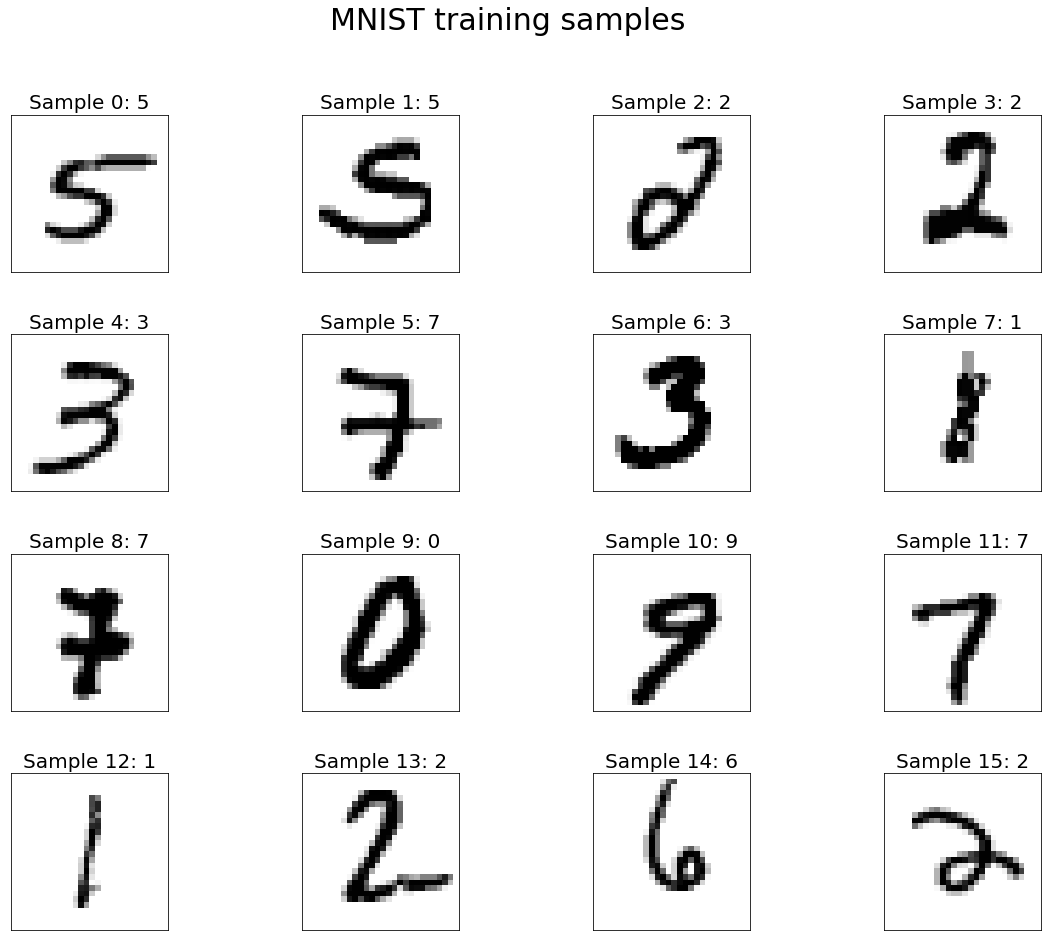

In [133]:
showImages(real_samples, true_labels = mnist_labels)

## Section 1: Train a GAN on MNIST for image generation
In this first part, you are asked to train and test a GAN for the generation of fake handwritten numbers (and letters). 

Let's just recall what training a model means in machine learning. It is in fact quite simple: given a model architecture, use an optimization scheme to minimize a loss function (representing the gap between the data and the model predictions) in order to find the optimal values of the model parameters. In this Section, all of these elements are treated one by one.

Moreover, you receive reference Generator and Discriminator architectures. These neural network architectures should not be changed. Indeed, they are sufficient in order to get nice enough results while keeping the training time reasonable on a laptop CPU (normally less than 2 hours training).

However, if you want to train additional Generator and/or Discriminator models that could be larger or smaller (for improved results or faster training for example), feel free to create them by yourself, explain them with comments and name them differently.

### 1.a Generator class
The Generator class takes an input: the dimension of the latent space. Indeed, the generator will create an image (1x28x28) from an input latent vector (1 color i.e. gray-scale, 28x28 pixels). Typically, this vector is of dimension 100 with each entry sampled from a standard normal distribution or from an uniform distribution on [-1,1]. You are free to change this dimension and see what happens.

The latent space is thus a space where the information contained in the images is compressed/condensed. This latent space will be the focus of the second part of the homework.

In [134]:
# Dimension of the latent space
# Predefined value = 100

dim_latent_space = 100

The class below contains the reference Generator architecture. You don't have to worry about the initialization of the model, it is done automatically.

This architecture should not be changed.

The Generator takes a batch of latent vectors as input, and ouputs one 1x28x28 pixels image for each input.

In [135]:
class Generator(nn.Module):

    def __init__(self, dim_latent_space):
        super().__init__()
        self.dim_latent_space = dim_latent_space
        self.fc = nn.Linear(self.dim_latent_space, 64*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.trans_conv2 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.trans_conv3 = nn.ConvTranspose2d(32, 16, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(16)
        self.trans_conv4 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        
    def forward(self, x):                   # Input = batch_size*dim_latent_space
        x = self.fc(x)                      # Output = batch_size*(64*7*7)
        x = x.view(-1, 64, 7, 7)            # Output = batch_size*64*7*7
        x = self.trans_conv1(x)             # Output = batch_size*64*14*14
        x = F.relu(self.batch_norm1(x))
        x = self.trans_conv2(x)             # Output = batch_size*32*14*14
        x = F.relu(self.batch_norm2(x))
        x = self.trans_conv3(x)             # Output = batch_size*16*14*14
        x = F.relu(self.batch_norm3(x))     
        x = self.trans_conv4(x)             # Output = batch_size*1*28*28
        x = torch.tanh(x)
        return x

In [136]:
generator = Generator(dim_latent_space).to(device=device)

### 1.b Discriminator class
The class below contains the reference Discriminator architecture. You don't have to worry about the initialization of the model, it is done automatically.

This architecture should not be changed.

The Discriminitor takes a batch of 1x28x28 pixels images as input, and ouputs numbers between -inf and +inf. The activation of the last layer represents some likelihood of the image being fake or not, according to the model. Afterwards, it goes through a sigmoid function in order to scale numbers between 0 and 1. An output of 0 means that the model is certain that the corresponding input image is fake, and an output of 0 means that it is certain that it is real.

In [137]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1, bias=False)
        self.conv0_drop = nn.Dropout2d(0.25)
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_drop = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(128, 128, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_drop = nn.Dropout2d(0.25)
        self.fc = nn.Linear(128*7*7, 1)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):                               # Input = batch_size*1*28*28
        x = x.view(-1, 1, 28, 28)                 # Output = batch_size*1*28*28
        x = F.leaky_relu(self.conv0(x), negative_slope=0.2)         # Output = batch_size*32*14*14
        x = self.conv0_drop(x)
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)           # Output = batch_size*64*14*14
        x = self.conv1_drop(x)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)       # Output = batch_size*128*14*14
        x = self.conv2_drop(x)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)       # Output = batch_size*128*7*7
        x = self.conv3_drop(x)
        x = x.view(-1, 128*7*7)                       # Output = batch_size*(128*7*7)
        x = self.fc(x)                            # Output = batch_size*1
        #x = self.sigmoid(x)
        return x

In [138]:
discriminator = Discriminator().to(device=device)

### 1.c Number of parameters
This function counts and prints the number of parameters in any neural network model.

There should be no need to modify the function numberParameters.

In [139]:
def numberParameters(model, trainable = False, model_name = None):
    total_params = sum(param.numel() for param in model.parameters())
    if model_name != None:
        print("Number of parameters of " + model_name + ": " + str(total_params))
    return total_params

In [140]:
discriminator_params = numberParameters(discriminator, model_name = "discriminator")
generator_params = numberParameters(generator, model_name = "generator")

Number of parameters of discriminator: 246497
Number of parameters of generator: 377121


### 1.d Loss function
The loss function measures how good the model is. For the discriminator, it a binary classification problem: the discriminator tries to distinguish true data (label = 1) from fake generated ones (label = 0). Therefore, we use a Binary Cross Entropy loss. As the only goal of the generator is to fool the discriminator, it can also be expressed with a Binary Cross Entropy loss function. Think about what inputs we need to give to the loss function for the discriminator and for the generator.

You see that BCELoss is replaced by BCEWithLogitsLoss. Think about why this is, and how it links with the last layer of the given Discriminator architecture.

This loss function should not be changed.

In [141]:
# Loss function for the GAN

#loss_function_gan = nn.BCELoss()
loss_function_gan = nn.BCEWithLogitsLoss()

### 1.e Optimizers
Adam is one of the most famous adaptive stochastic gradient descent algorithm. It is massively used for training neural networks.

You can play around with the Adam parameters if you want.

In [142]:
# Adam optimization parameters
# Predefined values: lr_gan = 0.0002, betas_gan = (0.5, 0.999)
lr_gan = 0.0002
betas_gan = (0.5, 0.999)

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr_gan, betas = betas_gan)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr_gan, betas = betas_gan)

### 1.f Accuracy
We define one error measure as the accuracy reached by the discriminator for its predictions y_predicted, i.e. the ratio between the number of correct classifications and the total number of samples. We suppose that if 0.0 <= y_generated[i] <= 0.5, then it predicts a fake image and if 0.5 < y_generated[i] <= 1.0, it predicts a true image.

Task: complete the computeGANAccuracy function.

In [143]:
def computeGANAccuracy(y_predicted):
    
    #accuracy = 0.0
    correct = 0
    for pred in y_predicted:

      if pred > 0:
          #print("Correct classification")
          correct +=1
      if pred < 0:
          #print("Incorrect classification")
          correct += 0
    return correct/len(y_predicted)

### 1.g Defining hyperparameters and creating vectors to store accuracy during training
In this part, you are asked to initialize the training process (not the model). 

Let's just first define the number of iterations (epochs) that the training will last. Satisfactory results can be obtained with 5 epochs, but you can of course increase this value for a better training.

In [144]:
# Number of epochs for the training
# Predefined value: num_epochs_gan = 5

num_epochs_gan = 5

It is important to keep track of the evolution of the error metrics during the training process. A simple idea is to store the values of the metrics in arrays, at least after every epoch.

Task: Create arrays containing the accuracy for train and test sets, as well as the values of the discriminator loss and of the generator loss during the training. Compute the values before training.

In [145]:
arrayAccuracyTrain = []
arrayAccuracyTest = []
arrayLossDiscriminator = []
arrayLossGenerator = []

In [146]:
next(discriminator.parameters()).is_cuda

True

In [147]:
#example to loop on batch
"""for i_batch, sample_batched in enumerate(train_loader):
    evalTest = discriminator(sample_batched[0].to(device))"""

'for i_batch, sample_batched in enumerate(train_loader):\n    evalTest = discriminator(sample_batched[0].to(device))'

In [148]:
errorTest =[]
yTestPred = []
errorFake = []
yFake = []
with torch.no_grad():
    discriminator.eval()
    generator.eval()
    for i, test_batch in enumerate(test_loader):
        if i == 1:
            break

        data = test_batch[0].to(device)
        b_size = data.size(0)
        label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
        eval = discriminator(data).view(-1)
        print(data)
        print(eval)
        errorDiscriminator = loss_function_gan(eval, label)

        errorTest.append(errorDiscriminator)
        yTestPred.append(eval)

        #label.fill_(1.0)
        noise = torch.distributions.uniform.Uniform(-1, 1).rsample((b_size, dim_latent_space)).to(device=torch.device("cuda"))
        fakeData = generator(noise)
        evalFakeData = discriminator(fakeData).view(-1)
        evalFakeData2 = discriminator(fakeData)
        print(evalFakeData2)
        errorDfake = loss_function_gan(evalFakeData, label)
        print(fakeData)
        print(evalFakeData)
        print(errorDfake)
        errorFake.append(errorDfake)
        yFake.append(evalFakeData)


tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., 

In [149]:
print(errorTest)
print(yTestPred)

[tensor(0.6792, device='cuda:0')]
[tensor([0.0349, 0.0171, 0.0163, 0.0143, 0.0130, 0.0294, 0.0163, 0.0246, 0.0403,
        0.0281, 0.0347, 0.0262, 0.0431, 0.0366, 0.0389, 0.0238, 0.0211, 0.0173,
        0.0474, 0.0291, 0.0386, 0.0181, 0.0249, 0.0254, 0.0233, 0.0255, 0.0329,
        0.0330, 0.0299, 0.0318, 0.0350, 0.0274], device='cuda:0')]


In [150]:
print(errorFake)
print(yFake)

[tensor(0.6855, device='cuda:0')]
[tensor([0.0153, 0.0155, 0.0155, 0.0155, 0.0154, 0.0152, 0.0155, 0.0151, 0.0159,
        0.0157, 0.0155, 0.0150, 0.0154, 0.0158, 0.0153, 0.0153, 0.0155, 0.0154,
        0.0154, 0.0151, 0.0150, 0.0152, 0.0154, 0.0154, 0.0153, 0.0156, 0.0151,
        0.0148, 0.0150, 0.0155, 0.0155, 0.0158], device='cuda:0')]


In [151]:
#computeGANAccuracy(yTrainPred)
#computeGANAccuracy(yTestPred)

It is a good option to keep track of the evolution of how the generated images evolve for a reference sample of latent vectors.

Task: Define a sample of reference latent vectors.

In [152]:
# Reference latent vectors
fixed_noise = torch.distributions.uniform.Uniform(-1, 1).rsample((batch_size, dim_latent_space)).to(device=torch.device("cuda"))
# TO COMPLETE

### 1.h Training the GAN
This is finally the core part of this section: training your GAN.

The training will follow an easy structure. Here is the pseudo-code of the training process:


    for each epoch:

        for each batch:

            train the discriminator on the batch:

                generate fake data (same amount as size of the batch)

                predict if data from the batch and generated data are fake or not

                compute the discriminator loss function

                backpropagate the error in the discriminator

            train the generator on the batch

                generate fake data (same amount as size of the batch)

                predict if generated data are fake or not

                compute the generator loss function

                backpropagate the error in the generator

        end

    end

Task: Code the GAN training from the pseudo-code given above. Don't forget to switch between training and evaluation modes for the models, by using train() and eval() Pytorch functions. To understand what to do and why, look for their impact on specific layers of the networks. You may also use the time package in order to get information about the duration of the training.

In [153]:
# Training of the GAN

# TO COMPLETE
fakeImgList = []
fakeImgList2 = []
generatorLoss = []
discriminatorLoss = []
accuracyGAN = []
def training(nbEpoch):
    for epoch in range(nbEpoch):
        start = time.time()
        print(f"Start epoch: {epoch}")
        discriminator.train()
        generator.train()
        for i, data in enumerate(train_loader, start=0):


            real_gpu = data[0].to(device) #transfer the img data to gpu
            b_size = real_gpu.size(0)

            noise = torch.distributions.uniform.Uniform(-1, 1).rsample((b_size, dim_latent_space)).to(device=torch.device("cuda"))
            label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
            ##training Discriminator##
            ### TRUE DATA###

            outputDtdata = discriminator(real_gpu).view(-1)  #evaluation true data by the discriminator
            errorDtdata = loss_function_gan(outputDtdata, label) #compute loss
            discriminator.zero_grad()
            errorDtdata.backward() # propagate

            #FAKE DATA###
            fakeData = generator(noise) ## GENERATE FAKE DATA ##
            label.fill_(0.0)
            evaluationDiscriminatorFD = discriminator(fakeData.detach()).view(-1)  #evaluation fake data by the discriminator
            errorDfdata = loss_function_gan(evaluationDiscriminatorFD, label)#compute loss
            errorDfdata.backward() #propagate

            #Optimizer
            errorDiscriminator = errorDfdata + errorDtdata #add loss fake data + loss true data
            optimizer_discriminator.step()

            ##training generator##
            label.fill_(1.0)
            outputDfdata = discriminator(fakeData).view(-1)
            errorGenerator = loss_function_gan(outputDfdata, label)
            generator.zero_grad()
            errorGenerator.backward()
            optimizer_generator.step()

            #bothOutput = torch.cat([outputDfdata, outputDtdata])
            accTrue = computeGANAccuracy(outputDtdata)
            accFake = computeGANAccuracy(outputDfdata)
            #print(acc)

            if i % 50 == 0:
                print(f"epoch = {epoch}/{nbEpoch-1}, iter = {i}/{len(train_loader)}, lossD = {errorDiscriminator}, lossG ={errorGenerator}")

                    # Check how the generator is doing by saving G's output on fixed_noise
            if (i % 500 == 0) or ((epoch == nbEpoch-1) and (i == len(train_loader)-1)):
                with torch.no_grad():
                    generator.eval()
                    fake = generator(fixed_noise).detach().cpu()
                fakeImgList.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
                fakeImgList2.append(fake)

            # Save Losses for plotting later
            generatorLoss.append(errorGenerator.item())
            discriminatorLoss.append(errorDiscriminator.item())
            accuracyGAN.append((accTrue, accFake))
        ###Updata arrays of metrics###
        arrayAccuracyTrain.append((accTrue, accFake))
        arrayLossGenerator.append(errorGenerator.item())
        arrayLossDiscriminator.append(errorDiscriminator.item())
        #Test model during training
        with torch.no_grad():
            discriminator.eval()
            generator.eval()
            for i, data in enumerate(test_loader, start=0):

                real_iamges_gpu = data[0].to(device)
                b_size = real_gpu.size(0)
                outputTestdata = discriminator(real_iamges_gpu).view(-1)
                label = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
                #errorDtdata = loss_function_gan(outputTestdata, label)

                noise = torch.distributions.uniform.Uniform(-1, 1).rsample((b_size, dim_latent_space)).to(device=torch.device("cuda"))
                fakeData = generator(noise) ## GENERATE FAKE DATA ##
                label.fill_(0.0)
                outputDFakeData = discriminator(fakeData.detach()).view(-1)  #evaluation fake data by the discriminator
                #errorDfdata = loss_function_gan(evaluationDiscriminatorFD, label)#compute loss

                label.fill_(1.0)
                outputDfdata = discriminator(fakeData).view(-1)
                #errorGenerator = loss_function_gan(outputDfdata, label)
                #bothOutput = torch.cat([outputTestdata, outputDFakeData])
                accTrue = computeGANAccuracy(outputTestdata)
                accFake = computeGANAccuracy(outputDFakeData)
            arrayAccuracyTest.append((accTrue, accFake))

    end = time.time()
    return (end - start)


In [154]:
execTime = training(num_epochs_gan)
print(f'execution time = {execTime/60} minutes')

Start epoch: 0
epoch = 0/4, iter = 0/1875, lossD = 1.385690450668335, lossG =0.6779550313949585
epoch = 0/4, iter = 50/1875, lossD = 0.6647335290908813, lossG =1.7132351398468018
epoch = 0/4, iter = 100/1875, lossD = 0.19627182185649872, lossG =4.589264392852783
epoch = 0/4, iter = 150/1875, lossD = 0.16656462848186493, lossG =3.871607780456543
epoch = 0/4, iter = 200/1875, lossD = 0.3370289206504822, lossG =3.0299863815307617
epoch = 0/4, iter = 250/1875, lossD = 0.5757589340209961, lossG =3.3009018898010254
epoch = 0/4, iter = 300/1875, lossD = 0.7936615943908691, lossG =2.203969955444336
epoch = 0/4, iter = 350/1875, lossD = 0.6110622882843018, lossG =2.398688316345215
epoch = 0/4, iter = 400/1875, lossD = 0.8093944787979126, lossG =1.805660367012024
epoch = 0/4, iter = 450/1875, lossD = 0.8925613760948181, lossG =1.1755952835083008
epoch = 0/4, iter = 500/1875, lossD = 0.7643399834632874, lossG =1.9563162326812744
epoch = 0/4, iter = 550/1875, lossD = 0.8094305992126465, lossG =1.9

In [155]:
print(arrayAccuracyTrain)
print(arrayAccuracyTest)
print(arrayLossDiscriminator)
print(arrayLossGenerator)

[(0.8125, 0.21875), (0.46875, 0.34375), (0.78125, 0.09375), (0.78125, 0.15625), (0.75, 0.28125)]
[(0.8125, 0.1875), (0.875, 0.28125), (0.625, 0.0625), (0.875, 0.28125), (1.0, 0.28125)]
[0.9736769199371338, 1.0465675592422485, 0.8332169055938721, 0.8487395644187927, 0.9711119532585144]
[1.4409347772598267, 0.9972660541534424, 1.7919632196426392, 1.770721673965454, 1.1574982404708862]


### 1.i Plot the results
You should plot the evolution of the accuracy and of the loss function in function of the number of epochs, to see how efficient the training is. 

Task: Make those plots, as clean and readable as possible.

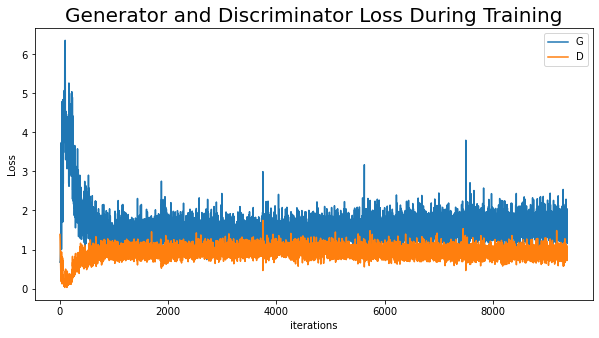

In [156]:
# Plots of accuracy and of loss function

# TO COMPLETE

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generatorLoss,label="G")
plt.plot(discriminatorLoss,label="D")
#plt.plot(accuracyGAN, label="A")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [157]:
print(np.mean(accuracyGAN))

0.47758833333333334


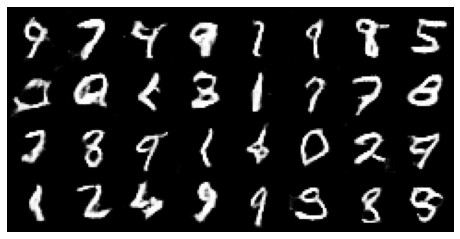

In [158]:
from IPython.display import HTML
import matplotlib.animation as animation
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fakeImgList]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

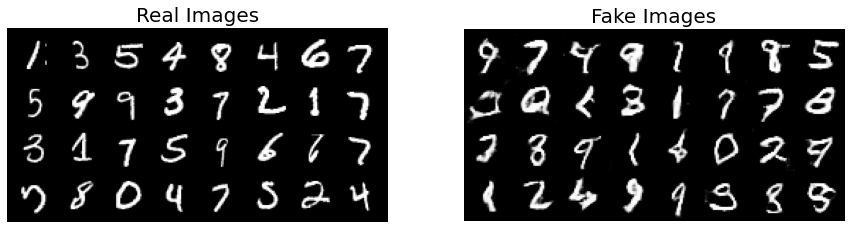

In [159]:
 #Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(fakeImgList[-1],(1,2,0)))
plt.show()

### Accuracy

21
torch.Size([32, 1, 28, 28])
torch.Size([122, 242])
torch.Size([32, 1, 28, 28])


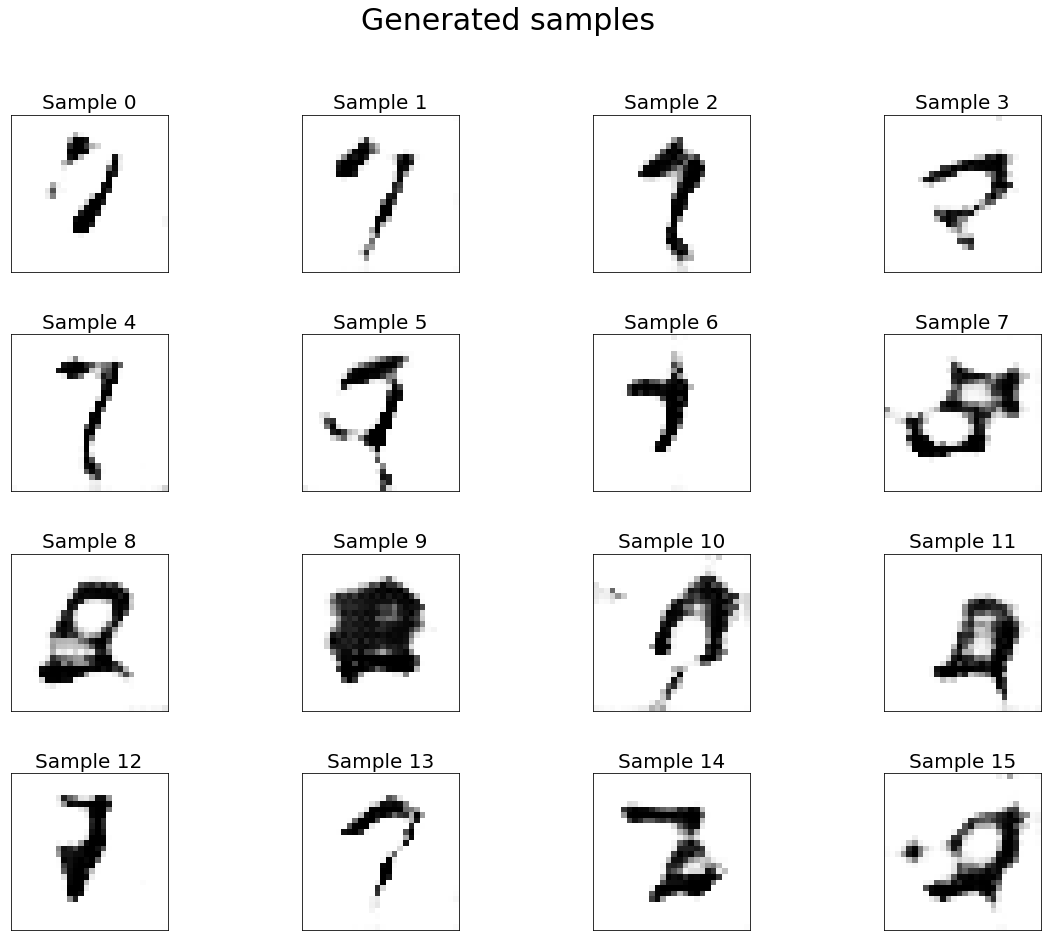

In [160]:
#showImages(fakeImgList[0])
print(len(fakeImgList2))
print(real_batch[0].size())
print(fakeImgList[0][0].size())
print(fakeImgList2[0].size())
showImages(fakeImgList2[2], generated=True, predicted=False)

### 1.j Save your models
A really useful feature for your experiments is to be able to save your models. This can be done with the torch.save function. In the function saveModel, a model is stored in the folder ./Models that you may want to create. The (date)time is used to always store your models with a different name and never lose some training that you would have done.

Be careful however: the saveModel function below stores the "state dictionary" of your model, not your model itself. 

You can of course modify the function saveModel as you wish.

In [161]:
def saveModel(model, model_name):
    now = datetime.now().strftime("%Y_%m_%d__%H_%M")
    torch.save(model.state_dict(), '../Models/' + model_name + '__' + now)

#### Example
#
# D = Discriminator().to(device=device)
# saveModel(D, "Discriminator")
#
##
# The model D has been saved as "Discriminator__2022_11_12__15_21" in the folder ./Models as your code finished running at
# 15:21 on the 12 November 2022.
##

### 1.k Load your models
You can also load models that you trained and saved earlier with the function loadModel.

However, be careful. You will have to first recreate a new instance of your class, and then import the state dictionary in the new instance. This means that the characteristics of your class should not have changed since then. In particular, the number of layers and the size of the layers need to match between the trained model and the most recent class in order to correctly assign the stored parameters. Moreover, there could be some trouble if you changed functions/methods from the class. 

You can of course modify the function loadModel as you wish.

In [162]:
def loadModel(model, model_name, date_time):
    model.load_state_dict(torch.load('../Models/' + model_name + '__' + date_time))
    model.eval()
    return model

#### Example
#
# D = Discriminator().to(device=device)
# loadModel(D, "Discriminator", "2022_11_12__15_21")
#
##
# The model "Discriminator__2022_11_12__15_21" from the folder ./Models has been loaded in the Discriminator D
##

## Section 2: Train a CNN on MNIST for image classification
In this second part, you are asked to train and test a CNN for the classification of handwritten numbers (and letters).

Therefore, you receive a reference CNN architecture that should not be changed. Training your CNN should be faster than training your GAN, so there is no fear about that.

However, if you want to train additional CNN models (for improved results or faster training for example), feel free to create them by yourself and name the classes differently.

### 2.a Number of classes
For classification task, it is of course necessary to know the number of classes possible. 

For the rest of the homework, pay attention not to confuse the label class (ex: the image represents a 2) and a model class (ex: the model is an instance of the CNN class).

There should be no need to modify the function numberClasses.

In [163]:
def numberClasses(dataset):
    n_classes = len(dataset.classes)
    return n_classes

In [164]:
n_classes = numberClasses(train_set)

### 2.b CNN class
The class below contains the reference CNN architecture. You don't have to worry about the initialization of the model, it is done automatically.

This architecture should not be changed.

The CNN architecture is defined by the number of classes. Indeed, for each entry it outputs a vector of size n_classes with values between -inf and +inf. This vector can be passed through the function scaleToProbabilities in order to get scaled and become somewhat interpretable as probabilities of belonging to one class. The function predictLabels extends the scaleToProbabilities function and selects the most activated/highest valued class as the CNN prediction.

There should be no need to modify the functions scaleToProbabilities and predictLabels, except playing with the scale_factor.

In [165]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Sequential(             # Images input is batch_size*1*28*28
            nn.Conv2d(1, 16, 5, 1, 2),          # Output is batch_size*16*28*28
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),        # Output is batch_size*16*14*14
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),         # Output is batch_size*32*14*14
            nn.ReLU(),                      
            nn.MaxPool2d(2),                    # Output is batch_size*32*7*7
        )
        # fully connected layer, output one number for each class
        self.out = nn.Sequential(         
            nn.Linear(32 * 7 * 7, self.n_classes),          # Output is batch_size*n_classes
        )
    
    def scaleToProbabilities(self, outmap, scale_factor = 3): 
        # scale_factor allows to scale your output before passing it into the softmax function 
        # in order to get numbers interpratble as probabilities
        
        flattened_outmap = outmap.view(outmap.shape[0], -1)
        outmap_std = torch.std(flattened_outmap, dim = 1).view(-1, 1)
        outmap_scaled_std = torch.div(outmap, outmap_std)
        probabilities = nn.functional.softmax(outmap_scaled_std*scale_factor, dim=1)
        return probabilities
    
    def predictLabels(self, outmap, scale_factor = 3):
        probabilities = self.scaleToProbabilities(outmap, scale_factor = 3)
        certainty, predicted_labels = torch.max(probabilities, 1)
        predicted_labels = predicted_labels.data.squeeze()
        certainty = certainty.data.squeeze()
        return predicted_labels, probabilities, certainty
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), 32 * 7 * 7)
        output = self.out(x)
        return output

In [166]:
cnn = CNN(n_classes).to(device=device)
cnn_params = numberParameters(cnn, model_name = "classifier")

Number of parameters of classifier: 28938


### 2.c Loss function
For classification tasks, the main loss function used is Cross Entropy. As entries, it takes the activations of last layer nodes  and the true labels of data (between 0 and n_classes-1). 

This loss function should not be changed.

In [167]:
# Loss function for the CNN

loss_function_cnn = nn.CrossEntropyLoss()

### 2.d Optimizer
Again, we will use Adam as an optimizer.

You can play around with the Adam parameters if you want.

In [168]:
# Adam optimization parameters
# Predefined values: lr_cnn = 0.01, betas_cnn = (0.9, 0.999)
lr_cnn = 0.01
betas_cnn = (0.9, 0.999)

optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=lr_cnn, betas = betas_cnn)

### 2.e Accuracy
We define one error measure as the accuracy reached by the CNN for its classifying predictions. In particular, we call accuracy the ratio between the number of correct classifications and the number of samples. We assume that the most activated output corresponds to the class prediction.

Task: complete the computeCNNAccuracy function.

In [169]:
def find_accuracy(model, data):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images, labels = images.cuda(), labels.cuda()
            #print(labels)
            test_output = cnn(images)
            #print(test_output)
            #print(test_output.size())
            #pred_y = torch.max(test_output, 1)[1].data.squeeze()
            pred_y, proba_y, certainty = model.predictLabels(test_output)
            '''
            print(pred_y)
            print(proba_y)
            print(certainty)
            '''
            correct += (pred_y == labels).sum().item()
            total += test_output.size(0)

            pass
    accuracy = (correct / total)*100

    return round(accuracy, 4)


chat= find_accuracy(cnn, test_loader)
chat

8.12

### 2.f Initialization of the training
In this part, you are asked to initialize the training process. 

Let's just first define the number of iterations (epochs) that the training will last. Satisfactory results can be obtained with 15 epochs, but you can of course increase this value for a better training.

In [170]:
# Number of epochs for the training
# Predefined value: num_epochs_cnn = 15

num_epochs_cnn = 15

It is important to keep track of the evolution of the error metrics during the training process. 

Task: Create arrays containing the accuracy of train and test sets, as well as the values of the CNN loss during the training. Compute the values before training.

In [171]:
# Error metrics at initialisation

# TO COMPLETE

### 2.g Training the CNN
This is finally the core part of this section: training your CNN.

The training will follow an easy structure. Here is the pseudo-code of the training process:

    for each epoch:

        for each batch:

            train the classifier on the batch:

                predict the labels

                compute the classifier loss function

                backpropagate the error in the cnn
                
        end

    end

Task: Code the CNN training from the pseudo-code given above. Don't forget to switch between training and evaluation modes for the model, by using train() and eval() Pytorch functions. You may also use the time package in order to get information about the duration of the training.

In [172]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

Epoch [1/15], Step [3268/60000 (5.45%)], Loss: 1.5173
Epoch [1/15], Step [6468/60000 (10.78%)], Loss: 1.5099
Epoch [1/15], Step [9668/60000 (16.11%)], Loss: 1.5295
Epoch [1/15], Step [12868/60000 (21.45%)], Loss: 1.5172
Epoch [1/15], Step [16068/60000 (26.78%)], Loss: 1.5104
Epoch [1/15], Step [19268/60000 (32.11%)], Loss: 1.4956
Epoch [1/15], Step [22468/60000 (37.45%)], Loss: 1.5456
Epoch [1/15], Step [25668/60000 (42.78%)], Loss: 1.4980
Epoch [1/15], Step [28868/60000 (48.11%)], Loss: 1.4750
Epoch [1/15], Step [32068/60000 (53.45%)], Loss: 1.4827
Epoch [1/15], Step [35268/60000 (58.78%)], Loss: 1.5111
Epoch [1/15], Step [38468/60000 (64.11%)], Loss: 1.4915
Epoch [1/15], Step [41668/60000 (69.45%)], Loss: 1.4958
Epoch [1/15], Step [44868/60000 (74.78%)], Loss: 1.4957
Epoch [1/15], Step [48068/60000 (80.11%)], Loss: 1.4746
Epoch [1/15], Step [51268/60000 (85.45%)], Loss: 1.4644
Epoch [1/15], Step [54468/60000 (90.78%)], Loss: 1.4653
Epoch [1/15], Step [57668/60000 (96.11%)], Loss: 1.4

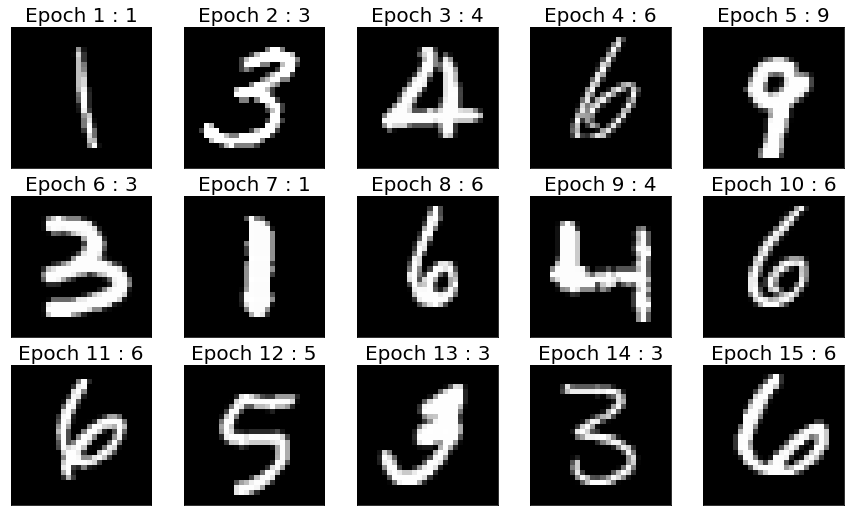

In [173]:
# Training of the CNN

# TO COMPLETE
from torch.utils.data import DataLoader
from torch.autograd import Variable


def train(num_epochs, cnn, loaders):

    cnn.train()
    accuracies = []
    max_accuracy = 0
    list_loses = []
    all_epoch_images = []
    all_epoch_labels = []

    # Train the model
    total_step = len(loaders)

    for epoch in range(num_epochs):
        correct = 0
        for i, (images, labels) in enumerate(loaders):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).float().to(device)
            b_y = Variable(labels).to(device)  # batch y
            #print(b_x.size())
            output = cnn(b_x)
            pred_y, proba_y, certainty = cnn.predictLabels(output)
            #print(b_y)
            #print(pred_y)
            #print(output)
            #print(b_y)
            loss = loss_function_cnn(proba_y, b_y)

            # clear gradients for this training step
            optimizer_cnn.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer_cnn.step()

            #store loss in list


            if (i+1) % 100 == 0:
                            print ('Epoch [{}/{}], Step [{}/{} ({:.2f}%)], Loss: {:.4f}'
                                   .format(epoch + 1, num_epochs, i*len(b_x)+100, len(loaders.dataset), (i*len(b_x)+100)*100/(len(loaders.dataset)), loss.item()))

            pass
          
        # store images and labels
        all_epoch_labels.append(output.data.max(1, keepdim=True)[1][0].item())
        all_epoch_images.append((images[0].reshape(28,28).to('cpu')))
        list_loses.append(round(loss.item(),4))
        
        accuracy = float(find_accuracy(cnn, test_loader))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy

        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')

        pass

    fig = plt.figure(figsize=(15,15))
    for n in range(len(all_epoch_images)):
      ax = plt.subplot(5,5,1+n)
      ax.set_title('Epoch ' + str(1+n) + ' : ' + str(all_epoch_labels[n]))
      plt.imshow(all_epoch_images[n], cmap='gray')
      plt.xticks([])
      plt.yticks([])
      
    #plt.savefig('./prediction_epochs.png', dpi=300)
    #plt.savefig('./prediction_epochs.svg', format='svg', dpi=300)

    plt.show()

    return best_model, accuracies, list_loses



#train(15, cnn, train_loader)

best_model, accuracies, list_loses = train(15, cnn, train_loader)

### 2.h Plot the results
Again, you should plot the evolution of the accuracy and of the loss function in function of the number of epochs, to see how efficient the training is. 

Task: Make those plots, as clean and readable as possible.

In [174]:
# Plots of accuracy and of loss function, images generated from your reference sample.
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#plot accuracies with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,16)), y=accuracies, mode='lines+markers', name='Accuracy'))
fig.update_layout(xaxis_title='Epochs', yaxis_title='Accuracy')
fig.show()

#plot loss with plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,16)), y=list_loses, mode='lines+markers', name='Loss'))
fig.update_layout(xaxis_title='Epochs', yaxis_title='Loss')
fig.show()

#subplots
subfig = make_subplots(rows=3, cols=1)

subfig.append_trace(go.Scatter(
    x = list(range(1,16)),
    y = accuracies, 
    mode = 'lines+markers',
), row=1, col=1)

subfig.append_trace(go.Scatter(
    x=list(range(1,16)), 
    y=list_loses, 
    mode='lines+markers', 
), row=2, col=1)

subfig.update_layout(height=800, width=900, title_text="Stacked Subplots")
subfig.update_yaxes(title_text='Accuracy', row=1, col=1)
subfig.update_yaxes(title_text='Loss', row=2, col=1)
#subfig.show()

## Part 2 coming soon
You now have operational GANs and CNNs for handwritten digits (and/or letters). In the second part of the homework, you will combine both networks in order to create what you want and learn more about those neural architectures.

### 3.1 COMBINE GENERATOR AND CLASSIFIER

In [175]:
#Example of latent vector
latentVector = torch.distributions.uniform.Uniform(-1, 1).rsample((1, dim_latent_space)).to(device=torch.device("cuda"))

In [176]:
latentVector

tensor([[-0.4970, -0.9758,  0.4932,  0.6531,  0.2085,  0.0520, -0.2824,  0.0742,
         -0.3627,  0.6452, -0.3547,  0.1124, -0.0444, -0.3828, -0.7795, -0.3943,
          0.0856,  0.0154, -0.1965, -0.3122, -0.1776,  0.5670,  0.2085,  0.0633,
         -0.8459,  0.9586, -0.3398,  0.8430,  0.2896, -0.4235,  0.5673,  0.8539,
         -0.7694,  0.3211,  0.2727, -0.1278, -0.7299,  0.6263,  0.2652,  0.9491,
         -0.8185,  0.1409,  0.7290,  0.9707, -0.8920, -0.4174,  0.5585, -0.2645,
          0.7230, -0.8616, -0.4086,  0.9736,  0.6941, -0.9079, -0.5150, -0.1613,
         -0.1519, -0.4544,  0.6502,  0.8409, -0.4234,  0.8091,  0.8890,  0.5660,
         -0.7533, -0.4739,  0.2208,  0.0044,  0.5650, -0.5802, -0.2309,  0.9503,
         -0.8058, -0.9442, -0.1335,  0.3044,  0.5179,  0.2776, -0.2219, -0.9901,
         -0.9339, -0.0127, -0.4959,  0.7410, -0.8625,  0.4639,  0.5611, -0.1990,
          0.0495,  0.3626,  0.4886, -0.1171,  0.5685, -0.0886, -0.7326, -0.6372,
         -0.0907,  0.7537,  

In [177]:
print(latentVector.size())

torch.Size([1, 100])


In [178]:
latentVectorList = []
## GENERATE THE LATENT VECTORS ##
for i in range(1000):
    latentVector = torch.distributions.uniform.Uniform(-1, 1).rsample((1, dim_latent_space)).to(device=torch.device("cuda"))
    latentVectorList.append(latentVector)

In [179]:
## GENERATE THE IMAGE OF THE LATENT VECTOR AND PREDICT HIS LABEL ##
with torch.no_grad():
    generator.eval()
    cnn.eval()
    generatedImages = [] #list of the image generated by generator
    predictedLabels = [] #list of the predict label by the cnn
    certaintyPredicted = [] #list of the certainty of being that label

    #labeled latent vector
    latentVector0= []
    latentVector1= []
    latentVector2= []
    latentVector3= []
    latentVector4= []
    latentVector5= []
    latentVector6= []
    latentVector7= []
    latentVector8= []
    latentVector9= []

    for i in range(1000):
        genImage = generator(latentVectorList[i])
        cnnOutput = cnn(genImage)
        pred_y, proba_y, certainty = cnn.predictLabels(cnnOutput)
        #Treshold on the quality of the image
        if certainty > 0.8:
            generatedImages.append(genImage.cpu())
            predictedLabels.append(pred_y.cpu())
            certaintyPredicted.append(certainty)
            if pred_y == 0:
                latentVector0.append(latentVectorList[i])
            elif pred_y == 1:
                latentVector1.append(latentVectorList[i])
            elif pred_y == 2:
                latentVector2.append(latentVectorList[i])
            elif pred_y == 3:
                latentVector3.append(latentVectorList[i])
            elif pred_y == 4:
                latentVector4.append(latentVectorList[i])
            elif pred_y == 5:
                latentVector5.append(latentVectorList[i])
            elif pred_y == 6:
                latentVector6.append(latentVectorList[i])
            elif pred_y == 7:
                latentVector7.append(latentVectorList[i])
            elif pred_y == 8:
                latentVector8.append(latentVectorList[i])
            elif pred_y == 9:
                latentVector9.append(latentVectorList[i])



In [180]:
  #convert the list into vector to pass them to the function showImage
generatedImagesTensor = torch.Tensor(len(generatedImages), 1, 1, 28, 28)
torch.cat(generatedImages, out=generatedImagesTensor)

predictedLabelsTensor = torch.stack(predictedLabels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

An output with one or more elements was resized since it had shape [736, 1, 1, 28, 28], which does not match the required output shape [736, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



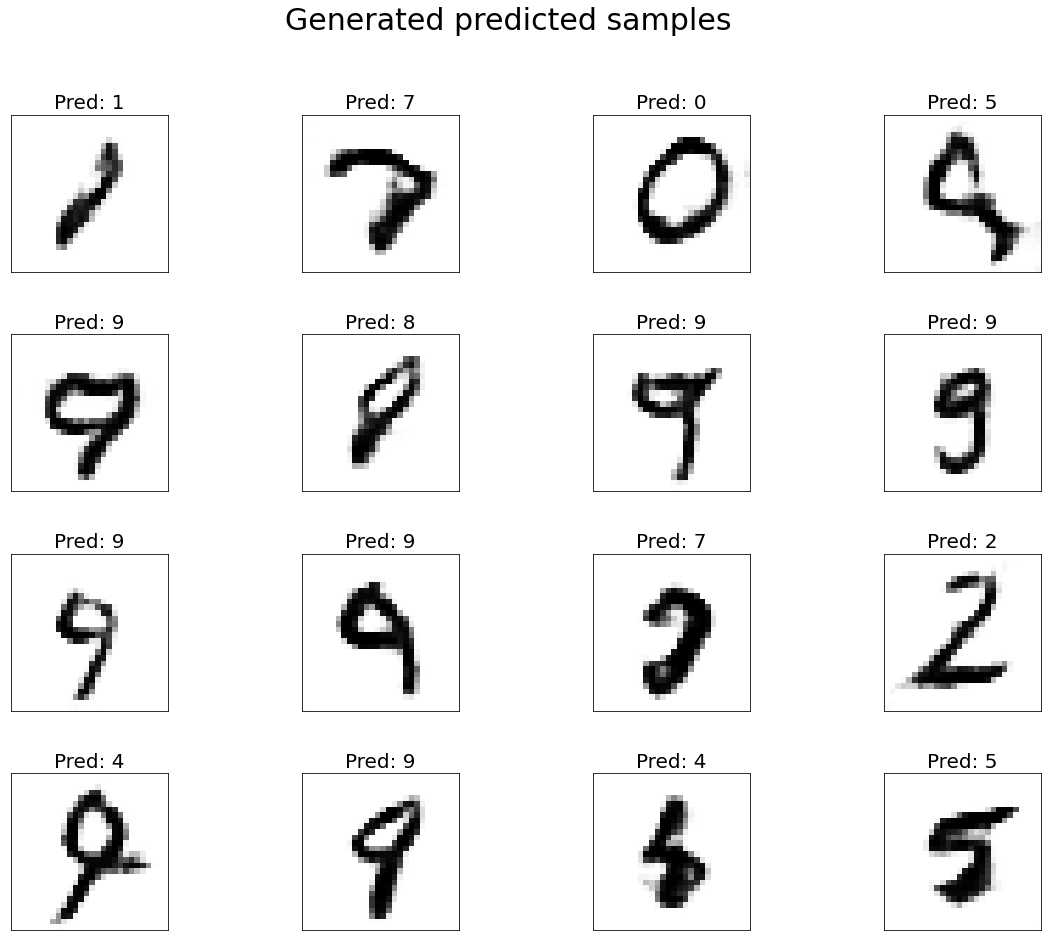

In [181]:
showImages(generatedImagesTensor, predicted_labels=predictedLabelsTensor,generated=True, predicted=True)

### 3.2 DISTRIBUTION OF CLASSES

In [182]:
print(predictedLabelsTensor.tolist())
shared_bins = np.histogram_bin_edges(predictedLabelsTensor.tolist(), bins=10)
shared_bins

[1, 7, 0, 5, 9, 8, 9, 9, 9, 9, 7, 2, 4, 9, 4, 5, 1, 9, 7, 9, 0, 3, 7, 2, 7, 1, 8, 2, 5, 9, 5, 5, 7, 1, 9, 9, 8, 3, 3, 4, 7, 9, 7, 2, 5, 6, 0, 7, 9, 0, 7, 8, 3, 1, 9, 1, 9, 7, 4, 2, 1, 0, 2, 8, 3, 6, 7, 9, 1, 7, 2, 3, 6, 3, 7, 7, 6, 1, 7, 1, 0, 0, 7, 2, 4, 5, 7, 7, 2, 1, 1, 0, 0, 8, 6, 8, 0, 0, 0, 4, 0, 2, 5, 7, 3, 0, 9, 0, 0, 9, 9, 7, 8, 9, 4, 0, 9, 1, 9, 5, 8, 9, 9, 1, 5, 3, 8, 3, 7, 7, 9, 0, 8, 9, 9, 7, 2, 3, 0, 4, 9, 9, 9, 7, 1, 7, 4, 3, 8, 9, 7, 5, 3, 7, 1, 7, 4, 5, 1, 7, 9, 8, 3, 3, 9, 6, 0, 8, 0, 8, 1, 9, 4, 0, 2, 1, 8, 9, 2, 7, 7, 0, 2, 6, 2, 5, 2, 5, 4, 3, 7, 7, 1, 7, 4, 7, 6, 7, 9, 7, 9, 0, 3, 4, 8, 6, 7, 7, 2, 8, 9, 4, 2, 3, 1, 1, 8, 4, 2, 8, 4, 8, 3, 0, 0, 9, 0, 9, 2, 5, 9, 9, 1, 4, 5, 9, 8, 5, 3, 7, 9, 8, 1, 8, 9, 2, 0, 1, 7, 8, 3, 5, 7, 7, 8, 7, 5, 0, 3, 7, 3, 9, 7, 3, 8, 3, 9, 3, 4, 9, 3, 0, 0, 7, 7, 3, 2, 8, 8, 8, 5, 6, 9, 6, 7, 7, 7, 2, 3, 5, 2, 7, 9, 3, 7, 7, 2, 8, 8, 2, 2, 7, 3, 5, 3, 2, 8, 8, 0, 7, 0, 9, 3, 1, 8, 2, 5, 7, 2, 7, 7, 0, 4, 0, 6, 7, 0, 6, 3, 2, 9, 4, 6, 

array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ])

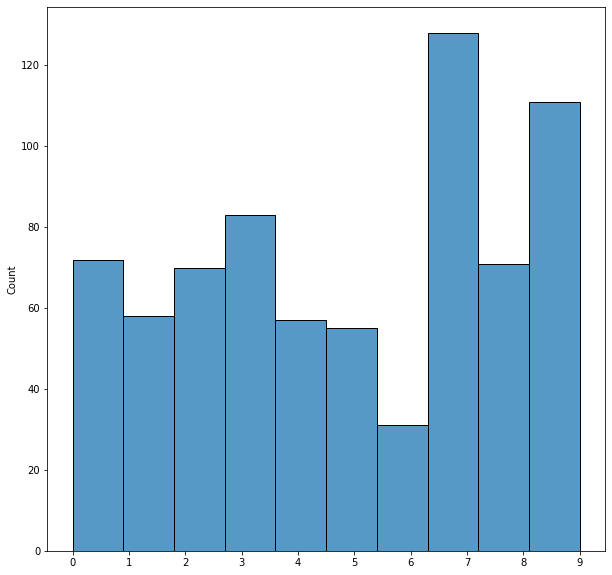

nombre de label 7: 128


In [183]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.histplot(predictedLabelsTensor.tolist(), bins=shared_bins)
plt.xticks([i for i in range(0, 10)])
plt.show()
#plt.xticks(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
#verif the distribution for number 7
nbseven = 0
for i in predictedLabelsTensor.tolist():
    #print(i)
    if i == 7:
        nbseven +=1
print(f'nombre de label 7: {nbseven}')

### 3.3 MEAN OF LATENT VECTORS

In [193]:
labeledLatentVector = {
    0 : latentVector0,
    1 : latentVector1,
    2 : latentVector2,
    3 : latentVector3,
    4 : latentVector4,
    5 : latentVector5,
    6 : latentVector6,
    7 : latentVector7,
    8 : latentVector8,
    9 : latentVector9,
}
meanLatentVectors= []

for i in range(0, 10):
    labelLatentVectori = labeledLatentVector[i]
    #print(labelLatentVectori)
    labeledLatentVectorTensorI = torch.Tensor(len(labelLatentVectori), 100).to(device)
    torch.cat(labelLatentVectori, out=labeledLatentVectorTensorI)
    #print(labeledLatentVectorTensorI.size())
    #print(labeledLatentVectorTensorI)
    meanLabeledLatentVector = torch.mean(labeledLatentVectorTensorI.cpu(), dim=0, keepdim=True)
    #print(type(meanLabeledLatentVector))
    #print(type(labeledLatentVectorTensorI))
    #print(f'mean size vector: {meanLabeledLatentVector.size()}')
    #print(f'labelLatentVectorSize: {labeledLatentVectorTensorI.size()}')
    meanLatentVectors.append(meanLabeledLatentVector)
    #print()

In [194]:
meanLatentVectors

[tensor([[-0.0324,  0.0794,  0.1411,  0.0916,  0.2846, -0.1540,  0.0352, -0.0623,
           0.1495, -0.0787,  0.0472,  0.0537, -0.1750, -0.0465, -0.0934, -0.1661,
           0.1626,  0.0921,  0.1856,  0.2366,  0.1267, -0.1457,  0.0490, -0.1250,
          -0.1011, -0.2747,  0.0017,  0.2093, -0.0191,  0.0025,  0.0733,  0.0077,
           0.1008, -0.1439,  0.1136,  0.0200, -0.0109,  0.0058,  0.2276, -0.2176,
          -0.0489,  0.0667, -0.0398, -0.0145,  0.0955,  0.1158,  0.1969, -0.0721,
           0.1632, -0.0610, -0.0006, -0.0057,  0.1620,  0.1560, -0.0700, -0.2724,
           0.1105, -0.1452,  0.0137, -0.0455, -0.0065,  0.0928, -0.0654,  0.0016,
          -0.0499, -0.0229, -0.0618, -0.1289,  0.1180,  0.1010, -0.0373, -0.1372,
          -0.0912,  0.1689, -0.0421,  0.1291, -0.1103,  0.1164,  0.0657, -0.0120,
          -0.0400, -0.0024,  0.0663, -0.1553,  0.0888, -0.1333,  0.0823,  0.1258,
           0.0619,  0.1528, -0.0158,  0.0559, -0.1280,  0.2148, -0.0711, -0.0152,
          -0.145

In [195]:
def latentToImage(latentVector):
    generatedImages = []
    labels = []
    with torch.no_grad():
        generator.eval()
        cnn.eval()
        if len(latentVector) > 1:
            for j in latentVector:
                generated = generator(j.to(device))
                cnnOutput = cnn(generated)
                pred_y, proba_y, certainty = cnn.predictLabels(cnnOutput)
                labels.append(pred_y.cpu())
                generatedImages.append(generated.detach().cpu())
            generatedImagesTensor = torch.Tensor(32, 1, 1, 28, 28)
            torch.cat(generatedImages[:32], out=generatedImagesTensor)
            showImages(generatedImagesTensor, generated=True, predicted=True, predicted_labels=labels)
        else:
            generated = generator(latentVector.to(device))
            cnnOutput = cnn(generated)
            pred_y, proba_y, certainty = cnn.predictLabels(cnnOutput)
            labels.append(pred_y.cpu())
            generatedImages.append(generated.detach().cpu())
            showImages(generated.detach().cpu(), generated=True, predicted=True, predicted_labels=labels)
    return generatedImages

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape [32, 1, 1, 28, 28], which does not match the required output shape [10, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



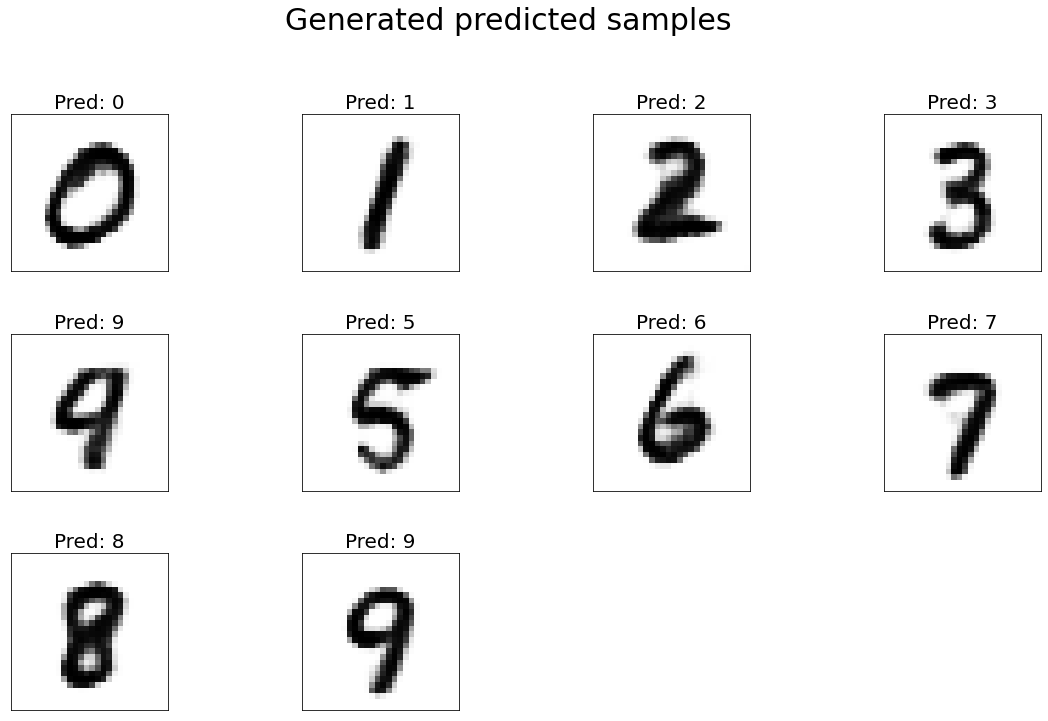

In [196]:
testMean = latentToImage(meanLatentVectors)

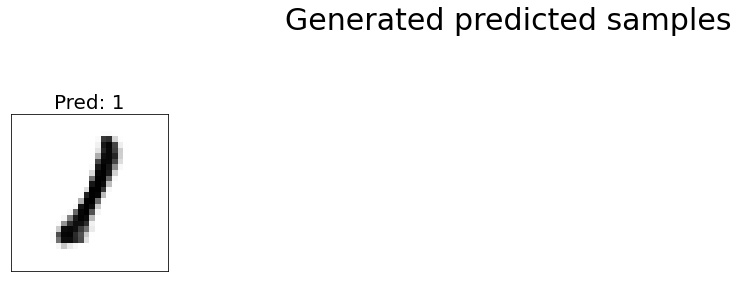

In [197]:
#exemple addition 0+3 almost 8 #Just wanted to see if it's work not for the project
zpluso = torch.add(meanLatentVectors[1], meanLatentVectors[2])
imgZplusO = latentToImage(zpluso)

# 3.4 Norm and distances

In [198]:
#compute norm
normMean0 = torch.linalg.vector_norm(meanLatentVectors[0])
label0Norm = torch.linalg.vector_norm(labeledLatentVector[0][0])

In [199]:
#compute distance
torch.cdist(meanLatentVectors[0].cpu(), labeledLatentVector[0][1].cpu())
#torch.cdist(labeledLatentVector[0][1].cpu(), meanLatentVectors[0].cpu())

tensor([[5.4407]])

In [200]:
#MDM criterion
def MDM(tensor, meanTensor):
    dist = [torch.cdist(tensor.cpu(), i.cpu()).item() for i in meanTensor]
    return np.argmin(dist) #return the indice of the min distance so in our case the class of the min distance between all the mean and our tensor

In [201]:
#si on change le treshold à 0.5 et on prend MDM(labeledLatentVector[4][1], meanLatentVectors) l'output sera la classe 8 qui est la bonne classe du latentVector alors que le cnn l'aura classifié dans la classe 4
MDM(labeledLatentVector[4][1], meanLatentVectors)

4

[tensor([[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9992],
           [-1.0000, -0.9994, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -0.9999, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000,
            -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
            -1.0000, -

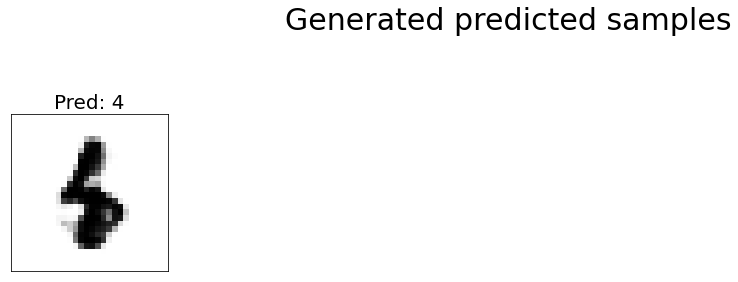

In [202]:
latentToImage(labeledLatentVector[4][1])

### 3.5 Interpolation for exploration

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape [32, 1, 1, 28, 28], which does not match the required output shape [31, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



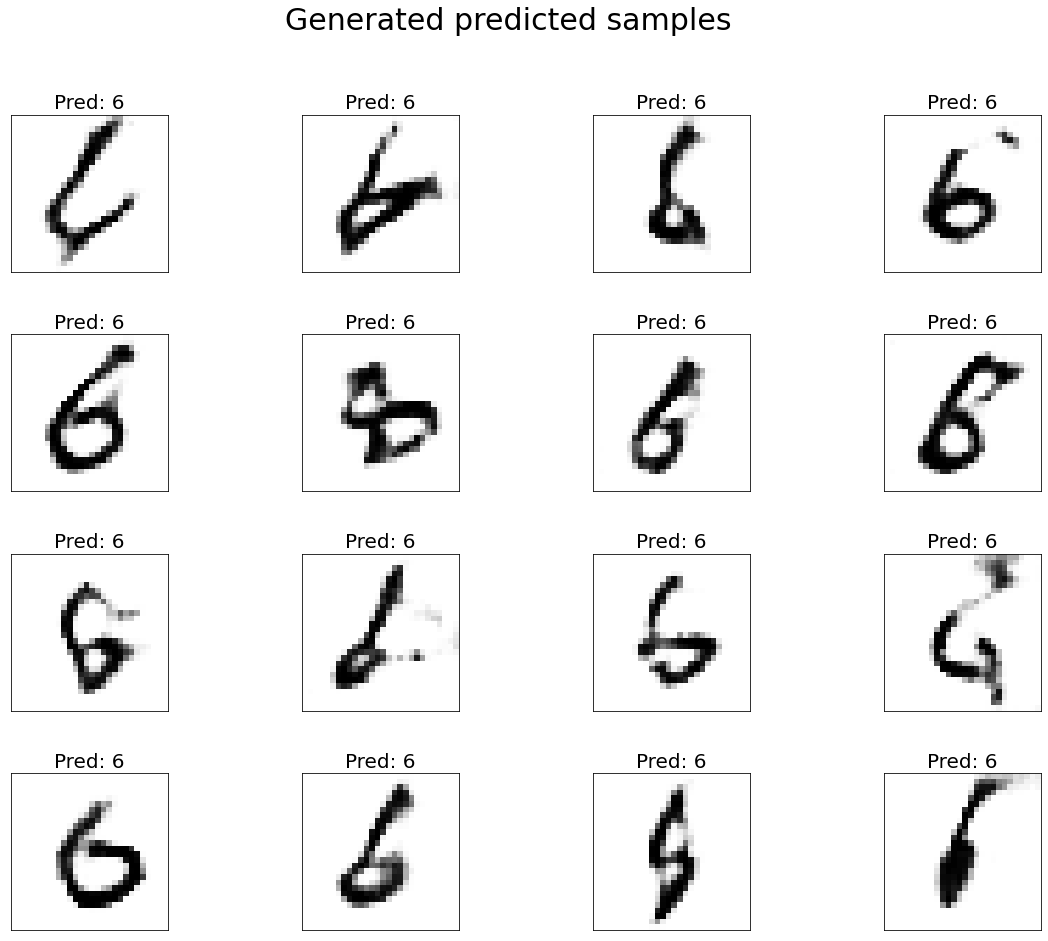

In [203]:
#choose 3 latent vector who represent nice images
imgLV6 = latentToImage(latentVector6)

In [204]:
extremeLatentVector6 = [latentVector6[0], latentVector6[1], latentVector6[8]]
extremeLatentVector3 = [latentVector3[4], latentVector3[12], latentVector3[8]]
extremeLatentVector5 = [latentVector5[1], latentVector5[2], latentVector5[7]]


In [205]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
# interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
# linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    vectors.insert(0, p1)
    vectors.insert(len(vectors)-1, p2)
    return np.asarray(vectors)

In [206]:
interpolated6 = interpolate_points(extremeLatentVector6[0].cpu(), extremeLatentVector6[1].cpu())
interpolated3 = interpolate_points(extremeLatentVector3[0].cpu(), extremeLatentVector3[1].cpu())
interpolated5 = interpolate_points(extremeLatentVector5[0].cpu(), extremeLatentVector5[1].cpu())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape [32, 1, 1, 28, 28], which does not match the required output shape [12, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



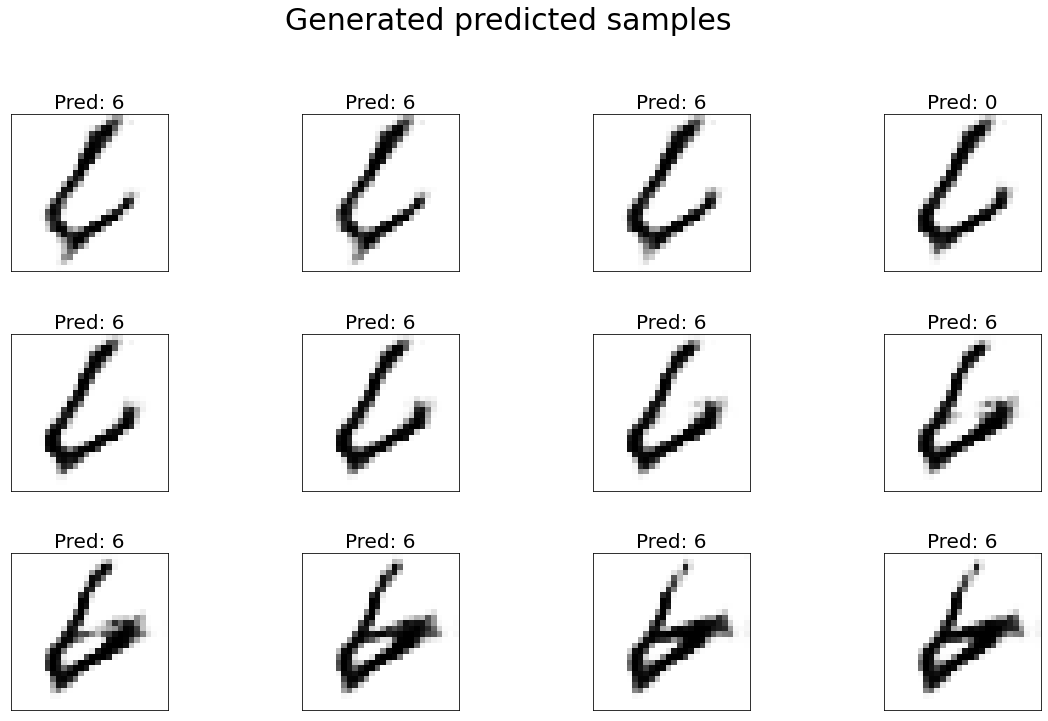

In [207]:
#sample 0 = P1 = Image we start from => sample 11 = P2 = Image we went to
imgInterpolated6 = latentToImage(interpolated6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape [32, 1, 1, 28, 28], which does not match the required output shape [12, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



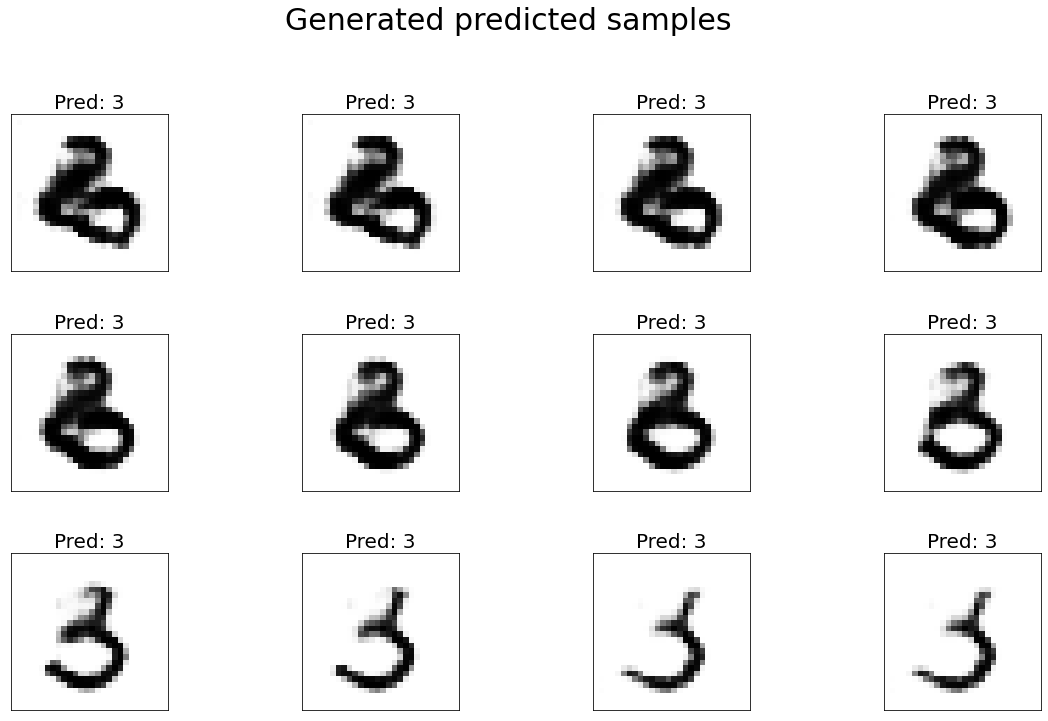

In [208]:
imgInterpolated3 = latentToImage(interpolated3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape [32, 1, 1, 28, 28], which does not match the required output shape [12, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



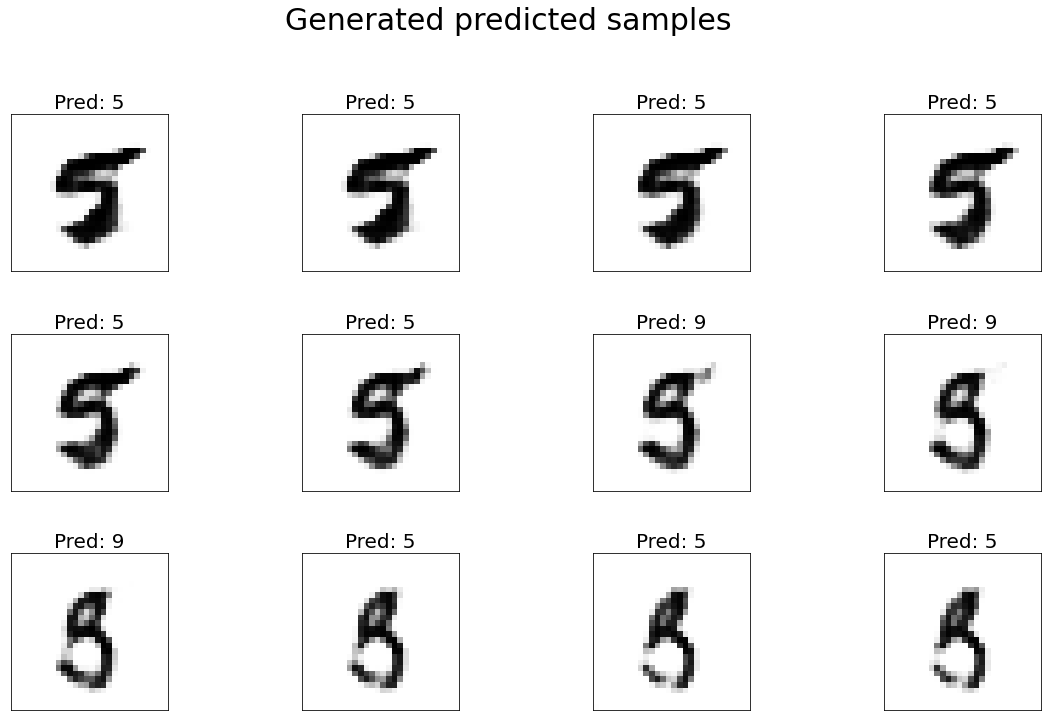

In [209]:
imgInterpolated5 = latentToImage(interpolated5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape 

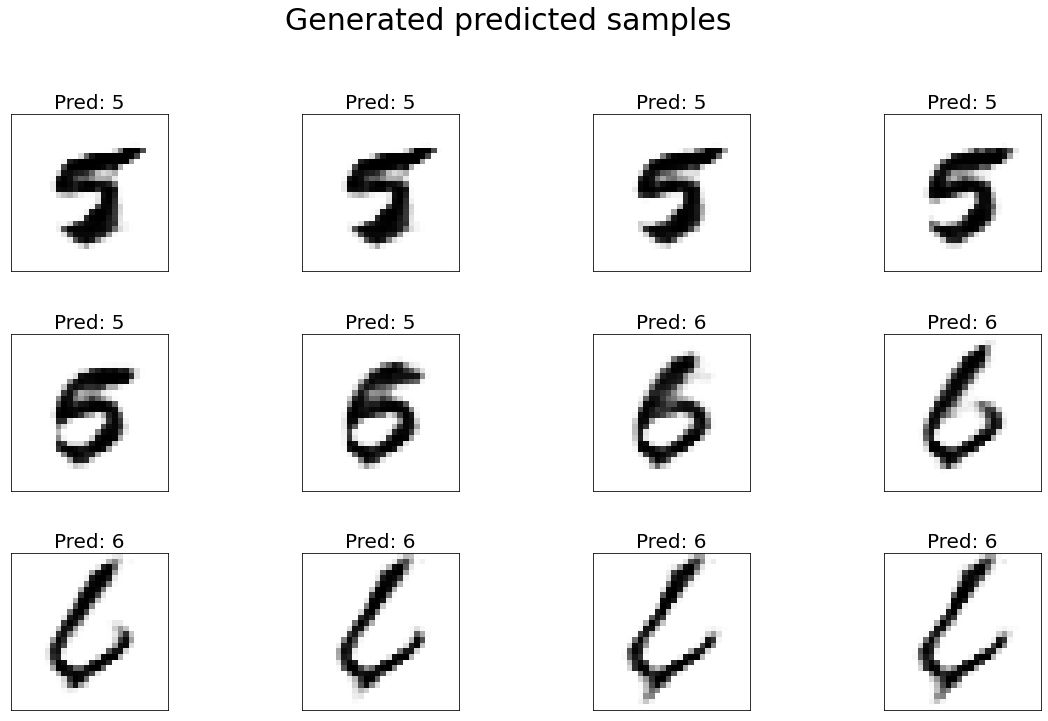

In [210]:
interpolatedDifferentClass = interpolate_points(extremeLatentVector5[0].cpu(), extremeLatentVector6[0].cpu())
imgInterpolatedDiffClass = latentToImage(interpolatedDifferentClass)

### 3.6 Noise for exploration

-0.5 0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape [32, 1, 1, 28, 28], which does not match the required output shape [10, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



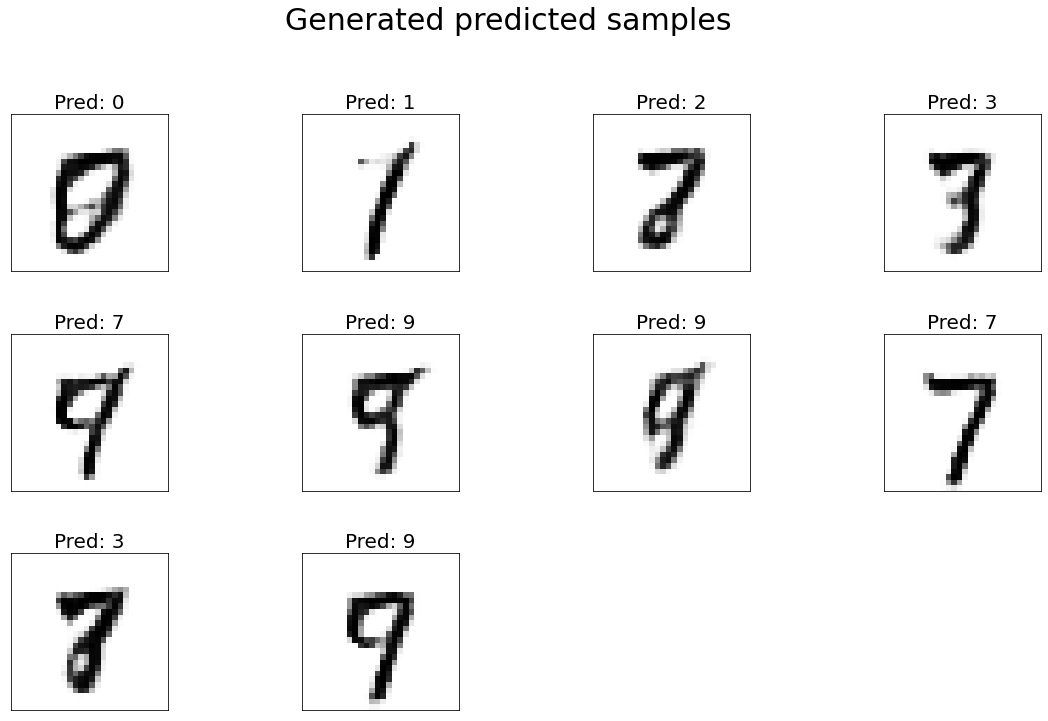

In [219]:
sigma = [0.1, 0.3, 0.5, 0.7, 0.9]
noiseLatentVector = torch.distributions.uniform.Uniform(-sigma[3], sigma[3]).rsample((1, dim_latent_space)).to(device)

print(-sigma[2], sigma[2])
variationLatentVector = [torch.add(i.cpu(), noiseLatentVector.cpu()) for i in meanLatentVectors]
#print((variationLatentVector[0].size()))
variationLatentImages = latentToImage(variationLatentVector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning:

An output with one or more elements was resized since it had shape [32, 1, 1, 28, 28], which does not match the required output shape [10, 1, 28, 28]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)



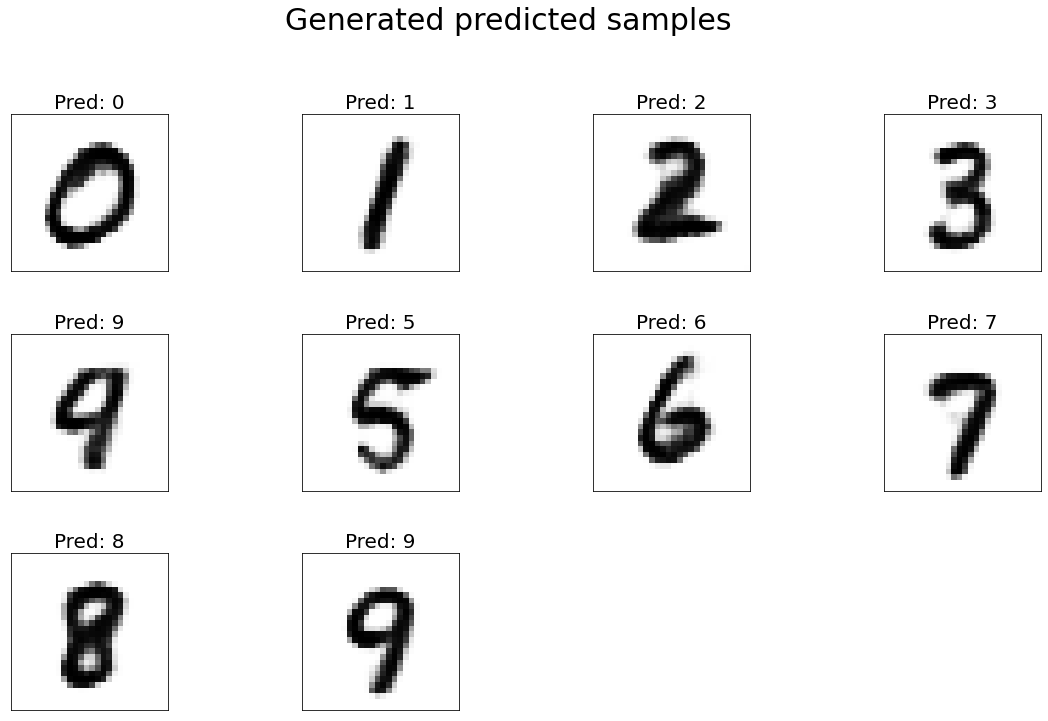

In [220]:
imgMeanLatentVector = latentToImage(meanLatentVectors)

# 4. Open message 

In [221]:
import os
wd = os.getcwd()

def saveLatentVectors(filename , latent_vectors):
  #check if file exists
  if os.path.exists(os.getcwd() + '/' + filename):
    os.remove(os.getcwd() + '/' + filename)

  torch.save(latent_vectors , os.getcwd() + '/' + filename)
  return

def loadLatentVectors(filename):
  latent_vectors = torch.load(os.getcwd() + '/' + filename)   
  return latent_vectors


In [222]:
#transform the mean latent vector into images
meanImages = []

#n = ["01100001011001110111001001101111"]
n = []
s = "01001001 01101000 01100001 01110110 01100101 01100100 01100101 01110110 01100101 01101100 01101111 01110000 01100101 01100100 01100001 01101000 01101001 01100111 01101000 01110100 01100101 01100011 01101000 01100001 01101100 01100111 01101111 01110010 01101001 01110100 01101000 01101101 01110100 01101111 01110100 01100101 01101100 01101100 01101001 01100110 01100001 01100111 01101001 01110010 01101100 01101100 01101001 01101011 01100101 01110011 01101101 01100101 00001101 00001010 00001101 00001010 00110001 00101110 01001110 01101111 00001101 00001010 00001101 00001010 "
s = s.replace(" ", "")
n.append(s)
# separate digits in list
input = [int(d) for d in str(n[0])]

#torch.cat(meanLatentVectors, out=meanTensor)
#meanTensor = torch.stack(meanLatentVectors).to(device)
for i in range(len(input)):
    generator.eval()
    cnn.eval()
    if input[i] == 0:
      for j in meanLatentVectors[0]:
        genMean = generator(j.to(device))
        meanImages.append(genMean.detach().cpu())
    else:
      for j in meanLatentVectors[1]:
        genMean = generator(j.to(device))
        meanImages.append(genMean.detach().cpu())


saveLatentVectors('MyLatentVector' , meanImages)

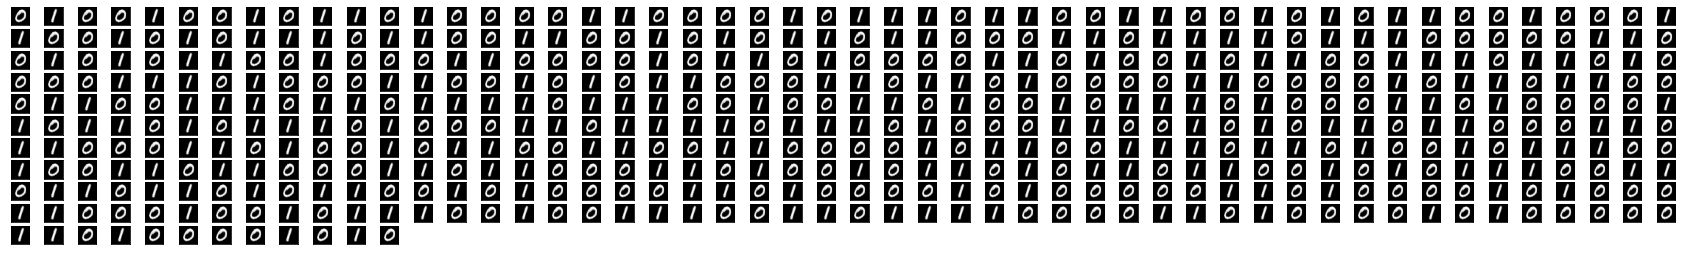

In [223]:
encrypted_latent_vector = loadLatentVectors('MyLatentVector')

plt.figure(figsize=(30,8))
for i in range(len(encrypted_latent_vector)):
  ax = plt.subplot(20, 50, 1+i)
  plt.imshow(encrypted_latent_vector[i].reshape(28,28), cmap='gray')
  plt.xticks([])
  plt.yticks([])

plt.show()

The following cell shows the binary translation

In [224]:
#@title Spoiler alert

a_binary_string = "01001001 00100000 01101000 01100001 01110110 01100101 00100000 01100100 01100101 01110110 01100101 01101100 01101111 01110000 01100101 01100100 00100000 01100001 00100000 01101000 01101001 01100111 01101000 00100000 01110100 01100101 01100011 01101000 00100000 01100001 01101100 01100111 01101111 01110010 01101001 01110100 01101000 01101101 00100000 01110100 01101111 00100000 01110100 01100101 01101100 01101100 00100000 01101001 01100110 00100000 01100001 00100000 01100111 01101001 01110010 01101100 00100000 01101100 01101001 01101011 01100101 01110011 00100000 01101101 01100101 00001010 00110001 00101110 00100000 01001110 01101111"

binary_values = a_binary_string.split()


ascii_string = ""
for binary_value in binary_values:
    an_integer = int(binary_value, 2)


    ascii_character = chr(an_integer)



    ascii_string += ascii_character



print(ascii_string)

I have developed a high tech algorithm to tell if a girl likes me
1. No
